Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, roc_auc_score, 
                             mean_absolute_error, mean_squared_error, r2_score)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings('ignore')

df_class = pd.read_csv('../data/classification-train.csv')
df_reg = pd.read_csv('../data/boston-regression.csv')

X_cls = df_class.drop('price_range', axis=1)
y_cls = df_class['price_range']
X_reg = df_reg.drop('MEDV', axis=1)
y_reg = df_reg['MEDV']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

def print_metrics(y_true, y_pred, y_proba=None, task='classification', model_name='Model'):
    print(f"--- {model_name} ---")
    if task == 'classification':
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")
        if y_proba is not None:
             roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
             print(f"ROC AUC (OVR): {roc_auc:.4f}")
        return acc
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"RMSE: {rmse:.4f} | R2: {r2:.4f}")
        return r2

print("Данные готовы")

Данные готовы


## Бейзлайн

In [3]:
# --- Классификация ---
rf_cls_base = RandomForestClassifier(random_state=42)
rf_cls_base.fit(X_train_c, y_train_c)
y_pred_c_base = rf_cls_base.predict(X_test_c)
y_proba_c_base = rf_cls_base.predict_proba(X_test_c)

# --- Регрессия ---
rf_reg_base = RandomForestRegressor(random_state=42)
rf_reg_base.fit(X_train_r, y_train_r)
y_pred_r_base = rf_reg_base.predict(X_test_r)

acc_base = print_metrics(y_test_c, y_pred_c_base, y_proba_c_base, 'classification', 'RF Baseline (Classification)')
r2_base = print_metrics(y_test_r, y_pred_r_base, task='regression', model_name='RF Baseline (Regression)')

--- RF Baseline (Classification) ---
Accuracy: 0.8925 | F1: 0.8933
ROC AUC (OVR): 0.9826
--- RF Baseline (Regression) ---
RMSE: 2.8110 | R2: 0.8923


## Тюнингуем модель
Несмотря на хорошую работу по умолчанию, мы можем улучшить результат, настроив главные параметры RF:\
n_estimators: Количество деревьев. Больше деревьев - лучше результат, но дольше время обучения\
max_depth: Максимальная глубина\
max_features: Количество признаков, рассматриваемых при каждом разбиении

Сначала посмотрим, как рост числа деревьев влияет на ошибку\
Заметим, что точность быстро растет, но увеличене количества деревьев дальше 80 не имеет смысла

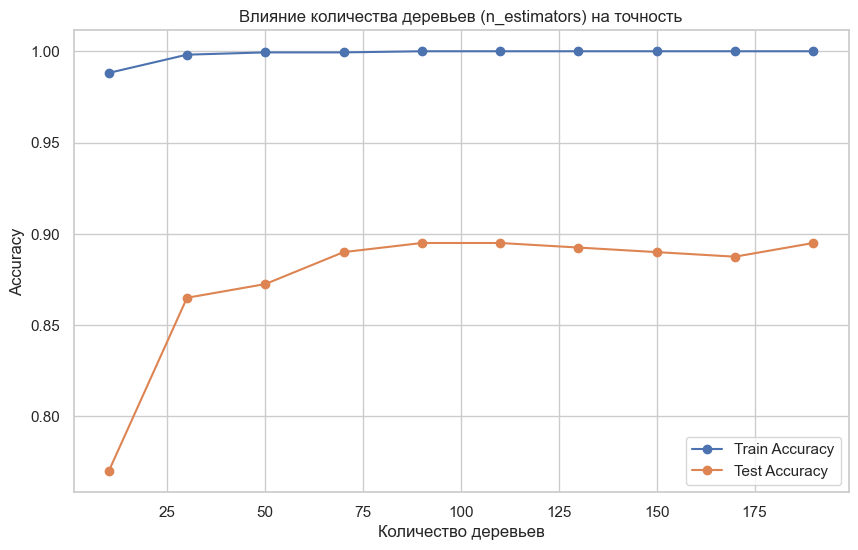

In [4]:
train_scores = []
test_scores = []
n_estimators_range = range(10, 201, 20)

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train_c, y_train_c)
    train_scores.append(rf.score(X_train_c, y_train_c))
    test_scores.append(rf.score(X_test_c, y_test_c))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, test_scores, label='Test Accuracy', marker='o')
plt.title('Влияние количества деревьев (n_estimators) на точность')
plt.xlabel('Количество деревьев')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Теперь оптимизируем глубину и количество признаков, которые могут быть использованы
немного увеличили точность в классификации и немного потеряли в точности для регрессии

In [8]:
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'max_features': [0.5, 0.7, 0.9, 'sqrt'],
    'n_estimators': [50, 70, 80, 100]
}

# --- Классификация ---
grid_rf_cls = GridSearchCV(RandomForestClassifier(random_state=52), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_rf_cls.fit(X_train_c, y_train_c)

# --- Регрессия ---
grid_rf_reg = GridSearchCV(RandomForestRegressor(random_state=52), param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_rf_reg.fit(X_train_r, y_train_r)

print(f"Лучшие параметры (Class): {grid_rf_cls.best_params_}")
print(f"Лучший Cross-Val Accuracy: {grid_rf_cls.best_score_:.4f}")
print("-" * 30)
print(f"Лучшие параметры (Reg): {grid_rf_reg.best_params_}")
print(f"Лучший Cross-Val R2: {grid_rf_reg.best_score_:.4f}")

Лучшие параметры (Class): {'max_depth': 10, 'max_features': 0.7, 'n_estimators': 70}
Лучший Cross-Val Accuracy: 0.8988
------------------------------
Лучшие параметры (Reg): {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
Лучший Cross-Val R2: 0.8528


Оценим тюнингованные модели
всё классно, хоть и есть пара выбросов в регрессии

--- RF Tuned (Classification) ---
Accuracy: 0.9100 | F1: 0.9102
ROC AUC (OVR): 0.9897


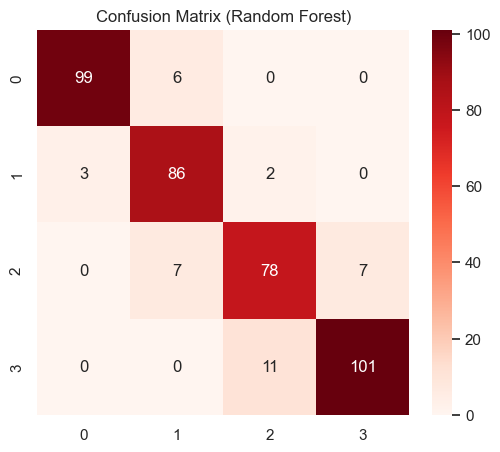

--- RF Tuned (Regression) ---
RMSE: 3.2658 | R2: 0.8546


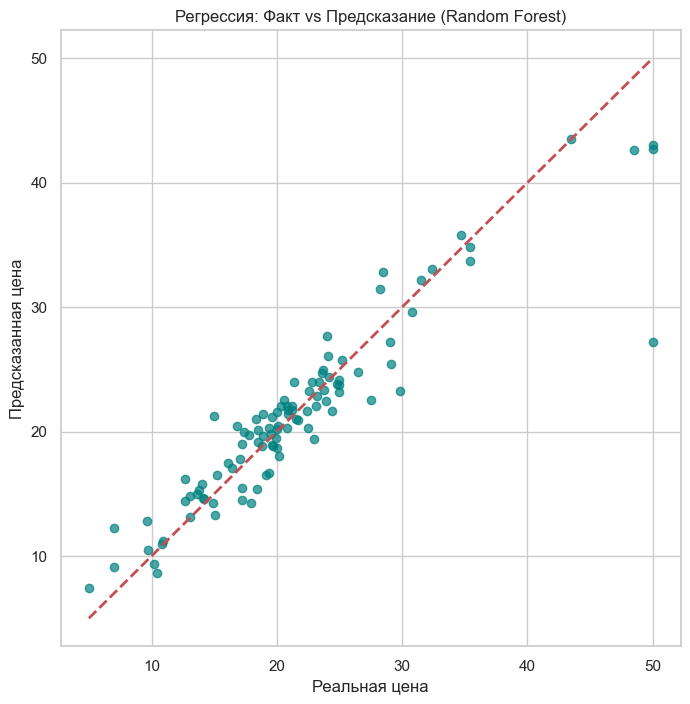

In [9]:
best_rf_cls = grid_rf_cls.best_estimator_
best_rf_reg = grid_rf_reg.best_estimator_

y_pred_c_tuned = best_rf_cls.predict(X_test_c)
y_proba_c_tuned = best_rf_cls.predict_proba(X_test_c)
y_pred_r_tuned = best_rf_reg.predict(X_test_r)

print_metrics(y_test_c, y_pred_c_tuned, y_proba_c_tuned, 'classification', 'RF Tuned (Classification)')

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_c, y_pred_c_tuned), annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

print_metrics(y_test_r, y_pred_r_tuned, task='regression', model_name='RF Tuned (Regression)')

plt.figure(figsize=(8, 8))
plt.scatter(y_test_r, y_pred_r_tuned, alpha=0.7, color='teal')
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.title('Регрессия: Факт vs Предсказание (Random Forest)')
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.show()

Интерпретация: Важность признаков\
лес обеспечивает гораздо более надежную оценку важности признаков, чем одиночное дерево, так как это усреднение важности по сотням деревьев\
\
Классификация: ram как и всегда доминирует. Но, в отличие от лог рег, лет не дает веса, а дает относительную важность, показывая, что ram делает около 60-70% всей работы по разделению\
\
Регрессия: тут тоже те же признаки как и всегда: LSTAT и RM. Лес умеет эффективно использовать оба признака, даже несмотря на их разную природу зависимости, благодаря ансамблированию

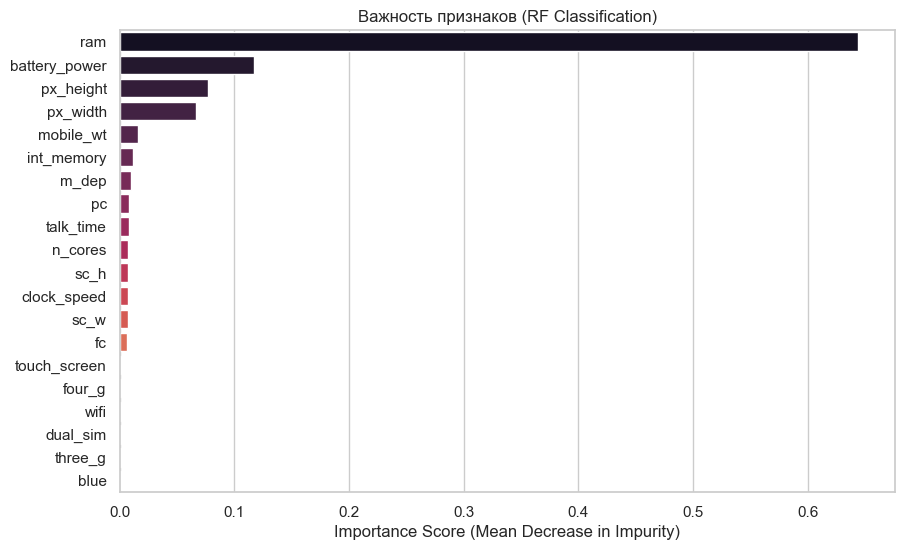

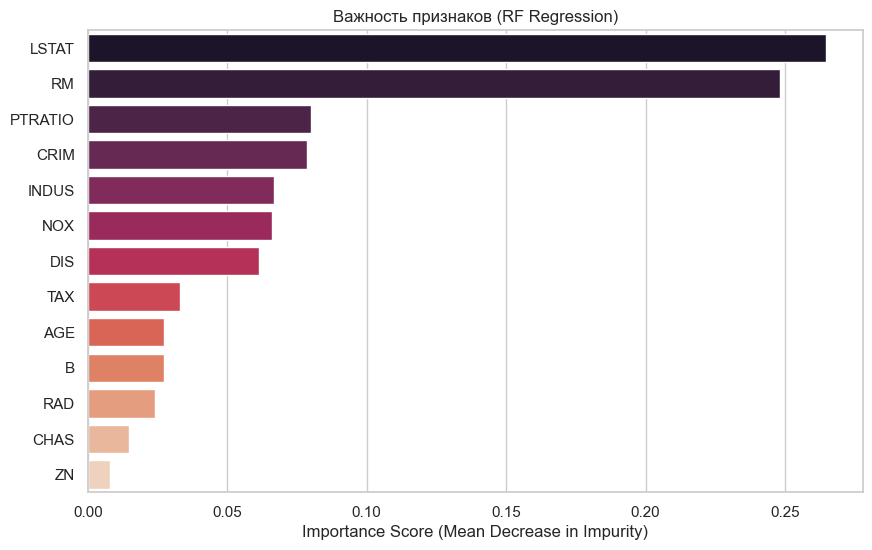

In [10]:
def plot_importance(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    sorted_features = np.array(features)[indices]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=sorted_features, palette='rocket')
    plt.title(title)
    plt.xlabel('Importance Score (Mean Decrease in Impurity)')
    plt.show()

plot_importance(best_rf_cls, X_cls.columns, 'Важность признаков (RF Classification)')
plot_importance(best_rf_reg, X_reg.columns, 'Важность признаков (RF Regression)')

## Своя реализация
Для своей реализации напишем bagging regressor, который обучает N моделей на N выборках - это, по сути лес, но мы не пишем все оптимизации для самой структуры данных\
\
В итоге получили результат, близкий к лесу из sklearn

In [24]:
from sklearn.tree import DecisionTreeRegressor as BaseEstimator

class CustomBaggingRegressor:
    def __init__(self, n_estimators=10, max_depth=None, sample_size=0.8):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.sample_size = sample_size
        self.estimators = []
        
    def fit(self, X, y):
        self.estimators = []
        X_np, y_np = np.array(X), np.array(y)
        n_samples = X_np.shape[0]
        
        sample_len = int(n_samples * self.sample_size)
        
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=sample_len, replace=True)
            X_sample, y_sample = X_np[indices], y_np[indices]
            
            tree = BaseEstimator(max_depth=self.max_depth, random_state=i)
            tree.fit(X_sample, y_sample)
            self.estimators.append(tree)
            
    def predict(self, X):
        X_np = np.array(X)
        predictions = np.array([est.predict(X_np) for est in self.estimators])
        return np.mean(predictions, axis=0)

custom_bag = CustomBaggingRegressor(n_estimators=100, max_depth=15, sample_size=0.8)
custom_bag.fit(X_train_r, y_train_r)
y_pred_r_custom = custom_bag.predict(X_test_r)

print_metrics(y_test_r, y_pred_r_custom, task='regression', model_name='Custom Bagging regression')

--- Custom Bagging regression ---
RMSE: 3.0247 | R2: 0.8752


0.875244246412936

## Теперь сведем результаты всех четырех лр в одну таблицу

результаты KNN, LogReg, DecTree возьмем из предыдущизх лаб
KNN - (acc = 0.94, r2 = 0.77)
LogReg - (acc = 0.88, r2 = 0.85)
DecTree - (acc = 0.83, r2 =	0.88)

,Model,Class Accuracy,Reg R2
0,KNN (Lab 1),0.9400,0.770000
1,Log Reg (Lab 2),0.8800,0.850000
2,Dec Tree (Lab 3),0.8300,0.880000
3,Random Forest (Lab 4),0.8925,0.892253


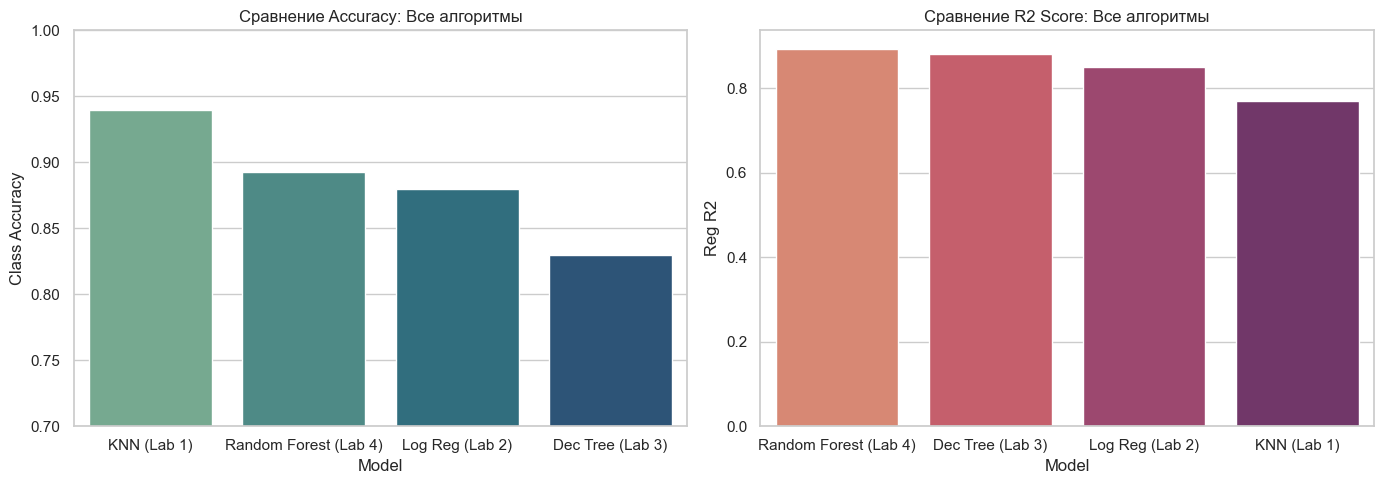

In [ ]:
results_all = {
    'Model': ['KNN (Lab 1)', 'Log Reg (Lab 2)', 'Dec Tree (Lab 3)', 'Random Forest (Lab 4)'],
    'Class Accuracy': [0.94, 0.88, 0.83, accuracy_score(y_test_c, y_pred_c_tuned)],
    'Reg R2': [0.77, 0.85, 0.88, r2_score(y_test_r, y_pred_r_tuned)]
}

df_final_comp = pd.DataFrame(results_all)
df_final_comp['Class Accuracy'] = df_final_comp['Class Accuracy'].astype(float)
df_final_comp['Reg R2'] = df_final_comp['Reg R2'].astype(float)

display(df_final_comp)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='Model', y='Class Accuracy', data=df_final_comp.sort_values(by='Class Accuracy', ascending=False), ax=ax[0], palette='crest')
ax[0].set_ylim(0.7, 1.0)
ax[0].set_title('Сравнение Accuracy: Все алгоритмы')

sns.barplot(x='Model', y='Reg R2', data=df_final_comp.sort_values(by='Reg R2', ascending=False), ax=ax[1], palette='flare')
ax[1].set_title('Сравнение R2 Score: Все алгоритмы')

plt.tight_layout()
plt.show()

## Выводы
Классификация: лес показал результат между KNN и LogReg. Вообще в идеальном мире на первом месте в этом топе должна быть LogReg т.к. зависимость (цена/ram) в этом датасете близка к линейной, которую логистическая регрессия находит оптимально, но скорее всего я недооптимизоровал модель и/или масштабирование данных вообще ухудшило результат тюнинга.\
\
Регрессия: лес занял первое место по метрике R^2 - он прекрасно справляется с нелинейностью данных Boston без необходимости ручного создания полиномиальных признаков, которые были нужны для полиномиальной регрессии\
\
отдельно хочется выделить что такие крутые результаты были достигнуты без масштабирования данных, и все наши подходы к оптимизации дали свои плоды